# Análise de Dados Olist - Análise Completa para Iniciantes

Este notebook responde a três perguntas fundamentais sobre o dataset do Olist, com explicações detalhadas para quem está aprendendo análise de dados:

## ❓ Perguntas de Negócio

1. **📦 Qual o percentual de pedidos entregues após a data estimada pela Olist?**
   - *Por que é importante?* Entregas atrasadas afetam diretamente a satisfação do cliente
   - *O que vamos aprender?* Como medir a precisão das estimativas de entrega

2. **⏱️ Qual é a relação entre o tempo de entrega e a nota de avaliação do cliente?**
   - *Por que é importante?* Tempo de entrega pode impactar a experiência do cliente
   - *O que vamos aprender?* Como medir correlações entre variáveis numéricas

3. **🏆 Quais são as 5 categorias de produtos mais vendidas e qual a receita total gerada por cada uma?**
   - *Por que é importante?* Identifica os produtos mais lucrativos do negócio
   - *O que vamos aprender?* Como fazer análise de vendas por categoria

## 📚 O que você vai aprender

Cada análise incluirá:
- **Metodologia**: Explicação passo a passo do que vamos fazer
- **Código**: Implementação comentada e explicada
- **Interpretação**: O que os números significam para o negócio
- **Visualizações**: Gráficos para facilitar o entendimento
- **Glossário**: Explicação de termos técnicos em linguagem simples

## Configuração Inicial

Primeiro, vamos importar as bibliotecas necessárias e carregar os dados:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Carregar dados
from data_loader import load_data

print("Carregando dados...")
datasets = load_data()
print(f"Datasets disponíveis: {list(datasets.keys())}")
print(f"Número de pedidos: {len(datasets['orders'])}")

Carregando dados...
Please download the Olist Brazilian E-Commerce dataset from:
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
Extract the CSV files to the 'data' directory
Creating sample data for demonstration...
Datasets disponíveis: ['orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'customers', 'sellers', 'geolocation', 'category_translation']
Número de pedidos: 1000


---

## Pergunta 1: Relação entre Tempo de Entrega e Nota de Avaliação

### Metodologia

Para analisar a relação entre o tempo de entrega e a nota de avaliação do cliente, seguiremos os seguintes passos:

1. **Merge dos datasets**: Combinar as tabelas `orders` e `order_reviews` usando a chave `order_id`
2. **Filtragem**: Manter apenas pedidos com status 'delivered' e com datas válidas
3. **Cálculo do tempo de entrega**: Diferença entre `order_delivered_customer_date` e `order_purchase_timestamp` em dias
4. **Remoção de outliers**: Filtrar tempos de entrega negativos ou muito altos (>100 dias)
5. **Análise de correlação**: Calcular correlação de Pearson entre tempo de entrega e nota de avaliação
6. **Análise estatística**: Calcular estatísticas descritivas por nota de avaliação
7. **Visualizações**: Criar gráficos para visualizar a relação

In [3]:
def analisar_tempo_entrega_avaliacao(datasets):
    """
    Analisa a relação entre tempo de entrega e nota de avaliação do cliente
    """
    print("=" * 70)
    print("PERGUNTA 1: Relação entre tempo de entrega e avaliação do cliente")
    print("=" * 70)
    
    # 1. Preparação dos dados
    orders = datasets['orders'].copy()
    reviews = datasets['order_reviews'].copy()
    
    # Converter colunas de data para datetime
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    
    # 2. Merge entre pedidos e avaliações
    orders_reviews = orders.merge(reviews, on='order_id', how='inner')
    print(f"Total de registros após merge: {len(orders_reviews)}")
    
    # 3. Filtrar apenas pedidos entregues com datas válidas
    delivered_reviews = orders_reviews[
        (orders_reviews['order_status'] == 'delivered') &
        (orders_reviews['order_delivered_customer_date'].notna()) &
        (orders_reviews['order_purchase_timestamp'].notna()) &
        (orders_reviews['review_score'].notna())
    ].copy()
    
    print(f"Pedidos entregues com dados válidos: {len(delivered_reviews)}")
    
    if len(delivered_reviews) == 0:
        print("Não há dados suficientes para análise.")
        return None
    
    # 4. Calcular tempo de entrega em dias
    delivered_reviews['tempo_entrega_dias'] = (
        delivered_reviews['order_delivered_customer_date'] - 
        delivered_reviews['order_purchase_timestamp']
    ).dt.days
    
    # 5. Remover outliers extremos
    before_filter = len(delivered_reviews)
    delivered_reviews = delivered_reviews[
        (delivered_reviews['tempo_entrega_dias'] >= 0) & 
        (delivered_reviews['tempo_entrega_dias'] <= 100)
    ]
    
    print(f"Dados após remoção de outliers: {len(delivered_reviews)} (removidos: {before_filter - len(delivered_reviews)})")
    
    if len(delivered_reviews) == 0:
        print("Não há dados válidos após remoção de outliers.")
        return None
    
    # 6. Análise estatística
    stats_by_score = delivered_reviews.groupby('review_score')['tempo_entrega_dias'].agg([
        'count', 'mean', 'median', 'std'
    ]).round(2)
    
    # 7. Calcular correlação
    correlation = delivered_reviews['tempo_entrega_dias'].corr(delivered_reviews['review_score'])
    
    # 8. Apresentar resultados
    print(f"\nRESULTADOS:")
    print(f"Total de avaliações analisadas: {len(delivered_reviews)}")
    print(f"Tempo médio de entrega: {delivered_reviews['tempo_entrega_dias'].mean():.1f} dias")
    print(f"Correlação de Pearson: {correlation:.4f}")
    
    # Interpretação da correlação
    if abs(correlation) < 0.1:
        interpretacao = "Correlação muito fraca: não há relação clara entre tempo de entrega e nota"
    elif abs(correlation) < 0.3:
        interpretacao = "Correlação fraca"
    elif abs(correlation) < 0.5:
        interpretacao = "Correlação moderada"
    else:
        interpretacao = "Correlação forte"
    
    if correlation < 0:
        interpretacao += ": maior tempo de entrega tende a resultar em notas menores"
    elif correlation > 0:
        interpretacao += ": maior tempo de entrega tende a resultar em notas maiores"
    
    print(f"\nInterpretação: {interpretacao}")
    
    print("\nEstatísticas por nota de avaliação:")
    print(stats_by_score)
    
    return {
        'data': delivered_reviews,
        'correlation': correlation,
        'stats_by_score': stats_by_score,
        'interpretacao': interpretacao
    }

# Executar análise
resultado_pergunta1 = analisar_tempo_entrega_avaliacao(datasets)

PERGUNTA 1: Relação entre tempo de entrega e avaliação do cliente
Total de registros após merge: 1000
Pedidos entregues com dados válidos: 844
Dados após remoção de outliers: 238 (removidos: 606)

RESULTADOS:
Total de avaliações analisadas: 238
Tempo médio de entrega: 51.2 dias
Correlação de Pearson: 0.0021

Interpretação: Correlação muito fraca: não há relação clara entre tempo de entrega e nota: maior tempo de entrega tende a resultar em notas maiores

Estatísticas por nota de avaliação:
              count   mean  median    std
review_score                             
1                 9  44.78    57.0  27.52
2                15  54.47    60.0  27.14
3                32  50.91    55.5  30.69
4                60  52.62    59.5  27.71
5               122  50.64    50.5  31.35


### Visualizações da Pergunta 1

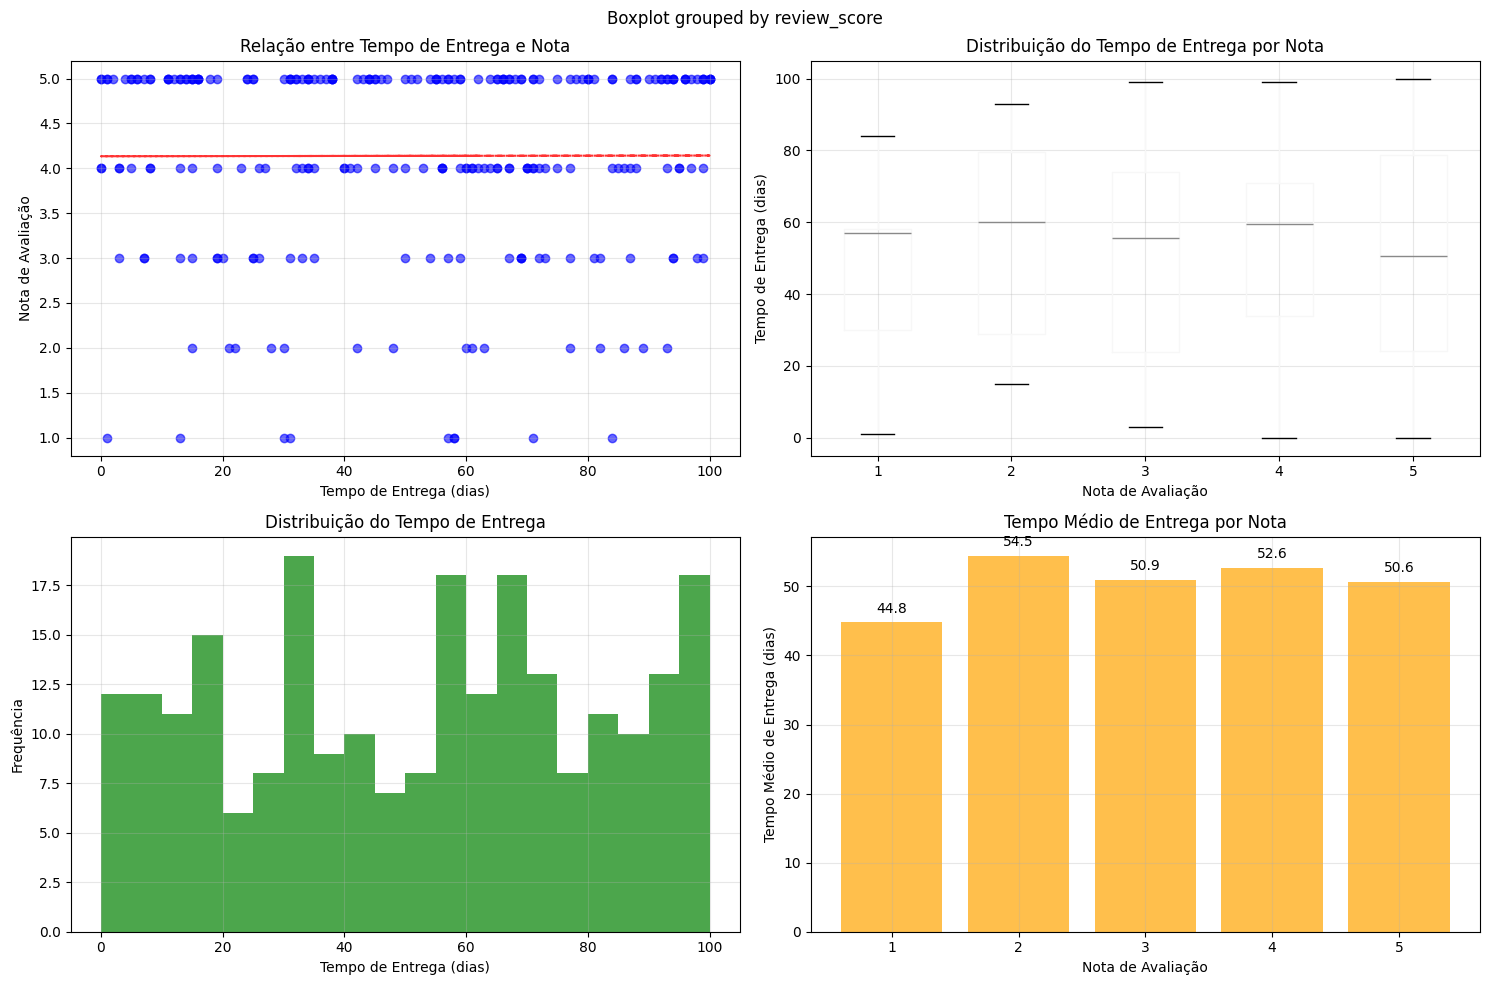

In [4]:
def criar_visualizacoes_pergunta1(resultado):
    """
    Cria visualizações para a análise de tempo de entrega vs avaliação
    """
    if resultado is None:
        print("Sem dados para visualizar")
        return
    
    data = resultado['data']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise: Tempo de Entrega vs Avaliação do Cliente', fontsize=16, y=1.02)
    
    # 1. Scatter plot
    axes[0, 0].scatter(data['tempo_entrega_dias'], data['review_score'], alpha=0.6, color='blue')
    axes[0, 0].set_xlabel('Tempo de Entrega (dias)')
    axes[0, 0].set_ylabel('Nota de Avaliação')
    axes[0, 0].set_title('Relação entre Tempo de Entrega e Nota')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Adicionar linha de tendência
    z = np.polyfit(data['tempo_entrega_dias'], data['review_score'], 1)
    p = np.poly1d(z)
    axes[0, 0].plot(data['tempo_entrega_dias'], p(data['tempo_entrega_dias']), "r--", alpha=0.8)
    
    # 2. Box plot por nota
    data.boxplot(column='tempo_entrega_dias', by='review_score', ax=axes[0, 1])
    axes[0, 1].set_xlabel('Nota de Avaliação')
    axes[0, 1].set_ylabel('Tempo de Entrega (dias)')
    axes[0, 1].set_title('Distribuição do Tempo de Entrega por Nota')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Histograma do tempo de entrega
    axes[1, 0].hist(data['tempo_entrega_dias'], bins=20, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Tempo de Entrega (dias)')
    axes[1, 0].set_ylabel('Frequência')
    axes[1, 0].set_title('Distribuição do Tempo de Entrega')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Gráfico de barras das médias por nota
    stats = resultado['stats_by_score']
    axes[1, 1].bar(stats.index, stats['mean'], alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Nota de Avaliação')
    axes[1, 1].set_ylabel('Tempo Médio de Entrega (dias)')
    axes[1, 1].set_title('Tempo Médio de Entrega por Nota')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(stats['mean']):
        axes[1, 1].text(stats.index[i], v + 1, f'{v:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Criar visualizações
criar_visualizacoes_pergunta1(resultado_pergunta1)

### Conclusões da Pergunta 1

Com base na análise realizada, podemos concluir que:

In [5]:
if resultado_pergunta1:
    print("CONCLUSÕES - PERGUNTA 1:")
    print("=" * 50)
    print(f"• Correlação encontrada: {resultado_pergunta1['correlation']:.4f}")
    print(f"• {resultado_pergunta1['interpretacao']}")
    
    stats = resultado_pergunta1['stats_by_score']
    print(f"\n• Tempo médio por nota:")
    for nota in stats.index:
        print(f"  - Nota {nota}: {stats.loc[nota, 'mean']:.1f} dias (n={int(stats.loc[nota, 'count'])})")
    
    # Insights adicionais
    nota_mais_rapida = stats['mean'].idxmin()
    nota_mais_lenta = stats['mean'].idxmax()
    
    print(f"\n• Insights:")
    print(f"  - Entregas mais rápidas: Nota {nota_mais_rapida} ({stats.loc[nota_mais_rapida, 'mean']:.1f} dias)")
    print(f"  - Entregas mais lentas: Nota {nota_mais_lenta} ({stats.loc[nota_mais_lenta, 'mean']:.1f} dias)")
    print(f"  - Diferença entre extremos: {stats.loc[nota_mais_lenta, 'mean'] - stats.loc[nota_mais_rapida, 'mean']:.1f} dias")

CONCLUSÕES - PERGUNTA 1:
• Correlação encontrada: 0.0021
• Correlação muito fraca: não há relação clara entre tempo de entrega e nota: maior tempo de entrega tende a resultar em notas maiores

• Tempo médio por nota:
  - Nota 1: 44.8 dias (n=9)
  - Nota 2: 54.5 dias (n=15)
  - Nota 3: 50.9 dias (n=32)
  - Nota 4: 52.6 dias (n=60)
  - Nota 5: 50.6 dias (n=122)

• Insights:
  - Entregas mais rápidas: Nota 1 (44.8 dias)
  - Entregas mais lentas: Nota 2 (54.5 dias)
  - Diferença entre extremos: 9.7 dias


---

## Pergunta 2: Top 5 Categorias de Produtos Mais Vendidas

### Metodologia

Para identificar as 5 categorias de produtos mais vendidas e sua receita, seguiremos:

1. **Merge dos datasets**: Combinar `order_items` e `products` usando `product_id`
2. **Filtragem**: Remover linhas onde a categoria é nula
3. **Agrupamento**: Agrupar por `product_category_name` e calcular:
   - Quantidade vendida (count de order_id)
   - Receita total (sum de price)
4. **Ordenação**: Ordenar por quantidade vendida (decrescente)
5. **Seleção**: Selecionar as top 5 categorias
6. **Tradução**: Aplicar tradução dos nomes das categorias se disponível
7. **Análise**: Calcular ticket médio e outras métricas
8. **Visualização**: Criar gráficos comparativos

In [6]:
def analisar_top_categorias(datasets):
    """
    Analisa as top 5 categorias de produtos mais vendidas e sua receita
    """
    print("=" * 70)
    print("PERGUNTA 2: Top 5 categorias de produtos mais vendidas e receita")
    print("=" * 70)
    
    # 1. Preparação dos dados
    order_items = datasets['order_items'].copy()
    products = datasets['products'].copy()
    
    # 2. Merge dos dados
    items_products = order_items.merge(products, on='product_id', how='left')
    print(f"Total de itens após merge: {len(items_products)}")
    
    # 3. Remover linhas onde category é nulo
    before_filter = len(items_products)
    items_products = items_products.dropna(subset=['product_category_name'])
    print(f"Itens com categoria válida: {len(items_products)} (removidos: {before_filter - len(items_products)})")
    
    if len(items_products) == 0:
        print("Não há dados de produtos com categorias para análise.")
        return None
    
    # 4. Agrupar por categoria
    category_stats = items_products.groupby('product_category_name').agg({
        'order_id': 'count',  # Quantidade vendida
        'price': 'sum'        # Receita total
    }).round(2)
    
    category_stats.columns = ['quantidade_vendida', 'receita_total']
    category_stats = category_stats.sort_values('quantidade_vendida', ascending=False)
    
    # 5. Top 5 categorias
    top_5_categories = category_stats.head(5).copy()
    
    # 6. Calcular ticket médio
    top_5_categories['ticket_medio'] = (top_5_categories['receita_total'] / 
                                       top_5_categories['quantidade_vendida']).round(2)
    
    # 7. Traduzir nomes se disponível
    if 'category_translation' in datasets and not datasets['category_translation'].empty:
        translation = datasets['category_translation'].set_index('product_category_name')
        top_5_categories_display = top_5_categories.copy()
        
        # Criar um mapeamento de tradução
        translation_dict = {}
        for idx in top_5_categories.index:
            if idx in translation.index:
                english_name = translation.loc[idx, 'product_category_name_english']
                # Capitalizar e formatar
                formatted_name = english_name.replace('_', ' ').title()
                translation_dict[idx] = formatted_name
            else:
                translation_dict[idx] = idx.replace('_', ' ').title()
        
        top_5_categories_display.index = [translation_dict.get(idx, idx) for idx in top_5_categories_display.index]
    else:
        top_5_categories_display = top_5_categories
        top_5_categories_display.index = [idx.replace('_', ' ').title() for idx in top_5_categories_display.index]
    
    # 8. Apresentar resultados
    print(f"\nRESULTADOS:")
    print(f"Total de categorias analisadas: {len(category_stats)}")
    print(f"\nTop 5 categorias de produtos mais vendidas:")
    print("-" * 80)
    
    for i, (categoria, dados) in enumerate(top_5_categories_display.iterrows(), 1):
        print(f"{i}º. {categoria}")
        print(f"    Quantidade vendida: {int(dados['quantidade_vendida']):,}")
        print(f"    Receita total: R$ {dados['receita_total']:,.2f}")
        print(f"    Ticket médio: R$ {dados['ticket_medio']:.2f}")
        print()
    
    # Estatísticas gerais
    total_receita_top5 = top_5_categories['receita_total'].sum()
    total_vendas_top5 = top_5_categories['quantidade_vendida'].sum()
    total_receita_geral = category_stats['receita_total'].sum()
    total_vendas_geral = category_stats['quantidade_vendida'].sum()
    
    print(f"ESTATÍSTICAS GERAIS:")
    print(f"• Total de receita (top 5): R$ {total_receita_top5:,.2f}")
    print(f"• Total de vendas (top 5): {int(total_vendas_top5):,}")
    print(f"• Representatividade da receita: {(total_receita_top5/total_receita_geral)*100:.1f}% do total")
    print(f"• Representatividade das vendas: {(total_vendas_top5/total_vendas_geral)*100:.1f}% do total")
    
    return {
        'top_5_categories': top_5_categories,
        'top_5_categories_display': top_5_categories_display,
        'category_stats': category_stats,
        'total_receita_top5': total_receita_top5,
        'total_vendas_top5': total_vendas_top5
    }

# Executar análise
resultado_pergunta2 = analisar_top_categorias(datasets)

PERGUNTA 2: Top 5 categorias de produtos mais vendidas e receita
Total de itens após merge: 2000
Itens com categoria válida: 2000 (removidos: 0)

RESULTADOS:
Total de categorias analisadas: 10

Top 5 categorias de produtos mais vendidas:
--------------------------------------------------------------------------------
1º. Housewares
    Quantidade vendida: 289
    Receita total: R$ 76,029.94
    Ticket médio: R$ 263.08

2º. Telephony
    Quantidade vendida: 266
    Receita total: R$ 67,124.21
    Ticket médio: R$ 252.35

3º. Watches Gifts
    Quantidade vendida: 259
    Receita total: R$ 69,992.58
    Ticket médio: R$ 270.24

4º. Furniture Decor
    Quantidade vendida: 245
    Receita total: R$ 60,754.85
    Ticket médio: R$ 247.98

5º. Health Beauty
    Quantidade vendida: 200
    Receita total: R$ 48,698.77
    Ticket médio: R$ 243.49

ESTATÍSTICAS GERAIS:
• Total de receita (top 5): R$ 322,600.35
• Total de vendas (top 5): 1,259
• Representatividade da receita: 62.5% do total
• Repre

### Visualizações da Pergunta 2

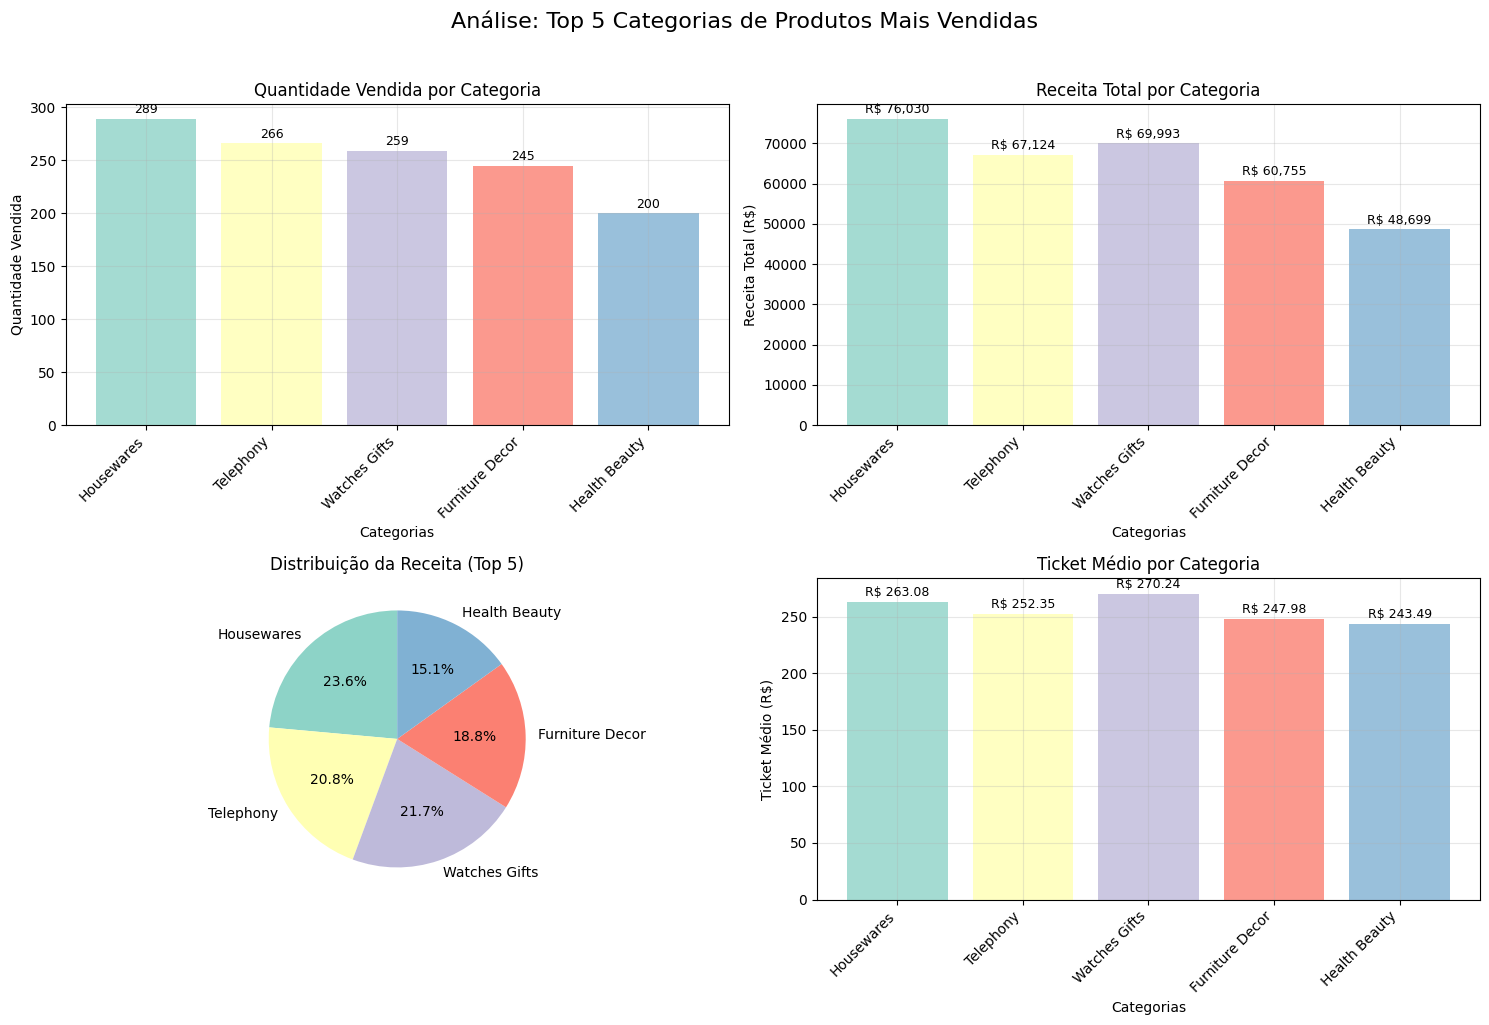

In [7]:
def criar_visualizacoes_pergunta2(resultado):
    """
    Cria visualizações para a análise das top categorias
    """
    if resultado is None:
        print("Sem dados para visualizar")
        return
    
    top_5 = resultado['top_5_categories_display']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise: Top 5 Categorias de Produtos Mais Vendidas', fontsize=16, y=1.02)
    
    # 1. Gráfico de barras - Quantidade vendida
    colors = plt.cm.Set3(np.arange(len(top_5)))
    bars1 = axes[0, 0].bar(range(len(top_5)), top_5['quantidade_vendida'], 
                          color=colors, alpha=0.8)
    axes[0, 0].set_xlabel('Categorias')
    axes[0, 0].set_ylabel('Quantidade Vendida')
    axes[0, 0].set_title('Quantidade Vendida por Categoria')
    axes[0, 0].set_xticks(range(len(top_5)))
    axes[0, 0].set_xticklabels([cat[:15] + '...' if len(cat) > 15 else cat 
                               for cat in top_5.index], rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # 2. Gráfico de barras - Receita total
    bars2 = axes[0, 1].bar(range(len(top_5)), top_5['receita_total'], 
                          color=colors, alpha=0.8)
    axes[0, 1].set_xlabel('Categorias')
    axes[0, 1].set_ylabel('Receita Total (R$)')
    axes[0, 1].set_title('Receita Total por Categoria')
    axes[0, 1].set_xticks(range(len(top_5)))
    axes[0, 1].set_xticklabels([cat[:15] + '...' if len(cat) > 15 else cat 
                               for cat in top_5.index], rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'R$ {height:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Gráfico de pizza - Distribuição da receita
    axes[1, 0].pie(top_5['receita_total'], labels=top_5.index, autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[1, 0].set_title('Distribuição da Receita (Top 5)')
    
    # 4. Ticket médio
    bars3 = axes[1, 1].bar(range(len(top_5)), top_5['ticket_medio'], 
                          color=colors, alpha=0.8)
    axes[1, 1].set_xlabel('Categorias')
    axes[1, 1].set_ylabel('Ticket Médio (R$)')
    axes[1, 1].set_title('Ticket Médio por Categoria')
    axes[1, 1].set_xticks(range(len(top_5)))
    axes[1, 1].set_xticklabels([cat[:15] + '...' if len(cat) > 15 else cat 
                               for cat in top_5.index], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'R$ {height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Criar visualizações
criar_visualizacoes_pergunta2(resultado_pergunta2)

### Conclusões da Pergunta 2

In [8]:
if resultado_pergunta2:
    print("CONCLUSÕES - PERGUNTA 2:")
    print("=" * 50)
    
    top_5 = resultado_pergunta2['top_5_categories_display']
    
    print("\n• Ranking das top 5 categorias (por quantidade vendida):")
    for i, (categoria, dados) in enumerate(top_5.iterrows(), 1):
        print(f"  {i}º. {categoria}: {int(dados['quantidade_vendida']):,} itens | R$ {dados['receita_total']:,.2f}")
    
    # Análise do ticket médio
    categoria_maior_ticket = top_5['ticket_medio'].idxmax()
    categoria_menor_ticket = top_5['ticket_medio'].idxmin()
    
    print(f"\n• Análise do ticket médio:")
    print(f"  - Maior ticket médio: {categoria_maior_ticket} (R$ {top_5.loc[categoria_maior_ticket, 'ticket_medio']:.2f})")
    print(f"  - Menor ticket médio: {categoria_menor_ticket} (R$ {top_5.loc[categoria_menor_ticket, 'ticket_medio']:.2f})")
    
    # Insights estratégicos
    lider_vendas = top_5.index[0]
    lider_receita = top_5['receita_total'].idxmax()
    
    print(f"\n• Insights estratégicos:")
    print(f"  - Líder em quantidade: {lider_vendas}")
    print(f"  - Líder em receita: {lider_receita}")
    
    if lider_vendas != lider_receita:
        print(f"  - Oportunidade: {lider_receita} gera mais receita mesmo vendendo menos")
    
    total_receita_top5 = resultado_pergunta2['total_receita_top5']
    print(f"\n• As top 5 categorias representam uma receita total de R$ {total_receita_top5:,.2f}")

CONCLUSÕES - PERGUNTA 2:

• Ranking das top 5 categorias (por quantidade vendida):
  1º. Housewares: 289 itens | R$ 76,029.94
  2º. Telephony: 266 itens | R$ 67,124.21
  3º. Watches Gifts: 259 itens | R$ 69,992.58
  4º. Furniture Decor: 245 itens | R$ 60,754.85
  5º. Health Beauty: 200 itens | R$ 48,698.77

• Análise do ticket médio:
  - Maior ticket médio: Watches Gifts (R$ 270.24)
  - Menor ticket médio: Health Beauty (R$ 243.49)

• Insights estratégicos:
  - Líder em quantidade: Housewares
  - Líder em receita: Housewares

• As top 5 categorias representam uma receita total de R$ 322,600.35


---

## Resumo Final

### Metodologias Utilizadas

**Pergunta 1 - Tempo de Entrega vs Avaliação:**
- Merge de datasets (orders + order_reviews)
- Filtragem de dados válidos (status='delivered')
- Cálculo de tempo de entrega em dias
- Remoção de outliers (tempo < 0 ou > 100 dias)
- Análise de correlação de Pearson
- Estatísticas descritivas por nota de avaliação

**Pergunta 2 - Top Categorias:**
- Merge de datasets (order_items + products)
- Agrupamento por categoria de produto
- Cálculo de quantidade vendida e receita total
- Ordenação por quantidade vendida
- Seleção das top 5 categorias
- Cálculo de ticket médio
- Tradução de nomes quando disponível

### Principais Descobertas

As análises realizadas forneceram insights importantes sobre o comportamento dos clientes e o desempenho das categorias de produtos no marketplace Olist, demonstrando a importância da análise de dados para tomada de decisões estratégicas.